In [33]:
import argparse
import copy
import os
import time
import warnings
from os import path as osp

import mmcv
import torch
import torch.distributed as dist
from mmcv import Config, DictAction
from mmcv.runner import get_dist_info, init_dist

import mmdet3d_plugin.models.detectors
from mmdet3d import __version__ as mmdet3d_version
from mmdet3d.apis import init_random_seed, train_model
from mmdet3d.datasets import build_dataset
from mmdet3d.models import build_model
from mmdet3d.utils import collect_env, get_root_logger
from mmdet.apis import set_random_seed
from mmseg import __version__ as mmseg_version

# Building arguments dict

In [34]:
class Args(argparse.Namespace):
    auto_resume=False
    autoscale_lr=False
    cfg_options=None
    config="configs/lidc/model/mv2d_lidc_r50_frcnn_roi_1024x1024_ep1.py"
    deterministic=False
    diff_seed=False
    gpu_id=0
    gpu_ids=None
    gpus=None
    launcher="none"
    local_rank=0
    no_validate=False
    options=None
    resume_from=None
    seed=0
    work_dir=None

args = Args()

In [35]:
args.config

'configs/lidc/model/mv2d_lidc_r50_frcnn_roi_1024x1024_ep1.py'

In [36]:
cfg = Config.fromfile(args.config)
if args.cfg_options is not None:
    cfg.merge_from_dict(args.cfg_options)

# # set multi-process settings
# setup_multi_processes(cfg)

# import modules from plguin/xx, registry will be updated
if cfg.get('plugin_dir', None):
    import importlib
    plugin_dir = cfg.plugin_dir
    _module_dir = os.path.dirname(plugin_dir)
    _module_dir = _module_dir.split('/')
    _module_path = _module_dir[0]

    for m in _module_dir[1:]:
        _module_path = _module_path + '.' + m
    plg_lib = importlib.import_module(_module_path)

# set cudnn_benchmark
if cfg.get('cudnn_benchmark', False):
    torch.backends.cudnn.benchmark = True

# work_dir is determined in this priority: CLI > segment in file > filename
if args.work_dir is not None:
    # update configs according to CLI args if args.work_dir is not None
    cfg.work_dir = args.work_dir
elif cfg.get('work_dir', None) is None:
    # use config filename as default work_dir if cfg.work_dir is None
    cfg.work_dir = osp.join('./work_dirs',
                            osp.splitext(osp.basename(args.config))[0])
if args.resume_from is not None:
    cfg.resume_from = args.resume_from

if args.auto_resume:
    cfg.auto_resume = args.auto_resume
    warnings.warn('`--auto-resume` is only supported when mmdet'
                    'version >= 2.20.0 for 3D detection model or'
                    'mmsegmentation verision >= 0.21.0 for 3D'
                    'segmentation model')

if args.gpus is not None:
    cfg.gpu_ids = range(1)
    warnings.warn('`--gpus` is deprecated because we only support '
                    'single GPU mode in non-distributed training. '
                    'Use `gpus=1` now.')
if args.gpu_ids is not None:
    cfg.gpu_ids = args.gpu_ids[0:1]
    warnings.warn('`--gpu-ids` is deprecated, please use `--gpu-id`. '
                    'Because we only support single GPU mode in '
                    'non-distributed training. Use the first GPU '
                    'in `gpu_ids` now.')
if args.gpus is None and args.gpu_ids is None:
    cfg.gpu_ids = [args.gpu_id]

if args.autoscale_lr:
    # apply the linear scaling rule (https://arxiv.org/abs/1706.02677)
    cfg.optimizer['lr'] = cfg.optimizer['lr'] * len(cfg.gpu_ids) / 8

# init distributed env first, since logger depends on the dist info.
if args.launcher == 'none':
    distributed = False
else:
    distributed = True
    init_dist(args.launcher, **cfg.dist_params)
    # re-set gpu_ids with distributed training mode
    _, world_size = get_dist_info()
    cfg.gpu_ids = range(world_size)


In [37]:
# init distributed env first, since logger depends on the dist info.
if args.launcher == 'none':
    distributed = False
else:
    distributed = True
    init_dist(args.launcher, **cfg.dist_params)
    # re-set gpu_ids with distributed training mode
    _, world_size = get_dist_info()
    cfg.gpu_ids = range(world_size)

# create work_dir
mmcv.mkdir_or_exist(osp.abspath(cfg.work_dir))
# dump config
cfg.dump(osp.join(cfg.work_dir, osp.basename(args.config)))
# init the logger before other steps
timestamp = time.strftime('%Y%m%d_%H%M%S', time.localtime())
log_file = osp.join(cfg.work_dir, f'{timestamp}.log')
# specify logger name, if we still use 'mmdet', the output info will be
# filtered and won't be saved in the log_file
# TODO: ugly workaround to judge whether we are training det or seg model
if cfg.model.type in ['EncoderDecoder3D']:
    logger_name = 'mmseg'
else:
    logger_name = 'mmdet'
logger = get_root_logger(
    log_file=log_file, log_level=cfg.log_level, name=logger_name)

# init the meta dict to record some important information such as
# environment info and seed, which will be logged
meta = dict()
# log env info
env_info_dict = collect_env()
env_info = '\n'.join([(f'{k}: {v}') for k, v in env_info_dict.items()])
dash_line = '-' * 60 + '\n'
logger.info('Environment info:\n' + dash_line + env_info + '\n' +
            dash_line)
meta['env_info'] = env_info
meta['config'] = cfg.pretty_text

# log some basic info
logger.info(f'Distributed training: {distributed}')
logger.info(f'Config:\n{cfg.pretty_text}')

# set random seeds
seed = init_random_seed(args.seed)
seed = seed + dist.get_rank() if args.diff_seed else seed
logger.info(f'Set random seed to {seed}, '
            f'deterministic: {args.deterministic}')
set_random_seed(seed, deterministic=args.deterministic)
cfg.seed = seed
meta['seed'] = seed
meta['exp_name'] = osp.basename(args.config)

2025-01-05 22:07:28,113 - mmdet - INFO - Environment info:
------------------------------------------------------------
sys.platform: linux
Python: 3.8.20 | packaged by conda-forge | (default, Sep 30 2024, 17:52:49) [GCC 13.3.0]
CUDA available: True
GPU 0: Quadro P600
CUDA_HOME: /home/ensai/anaconda3/envs/MV2Denv
NVCC: Cuda compilation tools, release 11.2, V11.2.152
GCC: gcc (conda-forge gcc 9.5.0-19) 9.5.0
PyTorch: 1.11.0.post202
PyTorch compiling details: PyTorch built with:
  - GCC 10.3
  - C++ Version: 201402
  - Intel(R) oneAPI Math Kernel Library Version 2022.1-Product Build 20220311 for Intel(R) 64 architecture applications
  - OpenMP 201511 (a.k.a. OpenMP 4.5)
  - LAPACK is enabled (usually provided by MKL)
  - NNPACK is enabled
  - CPU capability usage: AVX2
  - CUDA Runtime 11.2
  - NVCC architecture flags: -gencode;arch=compute_35,code=sm_35;-gencode;arch=compute_50,code=sm_50;-gencode;arch=compute_60,code=sm_60;-gencode;arch=compute_61,code=sm_61;-gencode;arch=compute_70,co

# Builda dataset


In [6]:

datasets = [build_dataset(cfg.data.train)]


loading annotations into memory...
Done (t=0.59s)
creating index...
index created!


## Build data loader 

(extracted from source-code at `train.py`)


In [7]:
from mmdet.datasets import build_dataloader as build_mmdet_dataloader

runner_type = 'EpochBasedRunner' if 'runner' not in cfg else cfg.runner[
    'type']

print(f"Runner type: {runner_type}")


data_loaders = [
    build_mmdet_dataloader(
        ds,
        cfg.data.samples_per_gpu,
        cfg.data.workers_per_gpu,
        # `num_gpus` will be ignored if distributed
        num_gpus=len(cfg.gpu_ids),
        dist=distributed,
        seed=cfg.seed,
        runner_type=runner_type,
        persistent_workers=cfg.data.get('persistent_workers', False))
    for ds in datasets
]

print(f"data_loaders: {data_loaders}")
print("One item in dataloader: ")

t_data_item = next(iter(data_loaders))
print(t_data_item)


Runner type: EpochBasedRunner
data_loaders: [<torch.utils.data.dataloader.DataLoader object at 0x7cd1abaadc70>]
One item in dataloader: 


From the dataloader, we can access all the information about our dataset that we previously define. 


In [8]:

# 
# Load the img path and gt_bboxes_3d of index 0
# 

import torch
from torchvision import transforms
from PIL import Image


# Query 1 image from lidc_data_info

cam00 = t_data_item.dataset.data_infos[0]['cams']['CAM_00']

# Load the image

image_path = cam00['data_path']
image_path


'./data/lidc/Images/Patient0000/Image_00.png'

In [9]:
t_data_item.dataset.get_data_info(0)   

{'sample_idx': 0,
 'timestamp': 0,
 'img_timestamp': [1735686000.0,
  1735686000.0,
  1735686000.0,
  1735686000.0,
  1735686000.0,
  1735686000.0,
  1735686000.0,
  1735686000.0,
  1735686000.0,
  1735686000.0],
 'img_filename': ['./data/lidc/Images/Patient0000/Image_00.png',
  './data/lidc/Images/Patient0000/Image_01.png',
  './data/lidc/Images/Patient0000/Image_02.png',
  './data/lidc/Images/Patient0000/Image_03.png',
  './data/lidc/Images/Patient0000/Image_04.png',
  './data/lidc/Images/Patient0000/Image_05.png',
  './data/lidc/Images/Patient0000/Image_06.png',
  './data/lidc/Images/Patient0000/Image_07.png',
  './data/lidc/Images/Patient0000/Image_08.png',
  './data/lidc/Images/Patient0000/Image_09.png'],
 'intrinsics': [array([[ 600.      ,    0.      , -400.390625,    0.      ],
         [   0.      ,  600.      , -400.390625,    0.      ],
         [   0.      ,    0.      ,    1.      ,    0.      ],
         [   0.      ,    0.      ,    0.      ,    1.      ]]),
  array([[ 6

## Get the toy example of 1 training data

We will create a toy example to run debug test on the model pipeline. 

Choose patient `0000`. 

In [34]:
import pickle

#
# Read original infos_train.pkl file
#

info_train_path = "data/lidc/lidc_infos_train.pkl"

with open(info_train_path, "rb") as f:
    lidc_infos_train = pickle.load(f)


# toy example
toy_idx = 0
for patient in lidc_infos_train['infos']:
    if patient['sample_id'] == toy_idx:
        toy_patient = patient
    else: continue

print(f"Toy example with patient: {toy_idx}")
print(f"number of nodules: {toy_patient['gt_boxes'].shape[0]}")
print(f"gt_boxes shape: {toy_patient['gt_boxes'].shape}")

# create a toy example train data
toy_infos_train = lidc_infos_train.copy()
toy_infos_train['infos'] = [toy_patient]

with open("data/lidc/toy_infos_train.pkl", "wb") as f:
    pickle.dump(toy_infos_train, f)



Toy example with patient: 0
number of nodules: 4
gt_boxes shape: (4, 7)


In [65]:
import json

# 
# Read original anno 2d json file
# 

info_train_2d_anno_path = "data/lidc/lidc_infos_train_2d_anno.coco.json"

with open(info_train_2d_anno_path, "r") as f:
    lidc_infos_train_2d_anno = json.load(f)


print(lidc_infos_train_2d_anno.keys())

toy_infos_train_anno = dict()
toy_annotations = []
toy_images = []
toy_categories = []

# filter annotation
for anno in lidc_infos_train_2d_anno['annotations']:
    if anno['image_id'].startswith(f"{toy_idx:04}cam"):
        toy_annotations.append(anno)

print(f"len toy_annotations: {len(toy_annotations)}")


# filter images
for img in lidc_infos_train_2d_anno['images']:
    if img['id'].startswith(f"{toy_idx:04}cam"):
        toy_images.append(img)

print(f"len toy_images: {len(toy_images)}")


# filter categories
for img in lidc_infos_train_2d_anno['images']:
    if img['id'].startswith(f"{toy_idx:04}cam"):
        toy_images.append(img)

print(f"len toy_images: {len(toy_images)}")

# write data
toy_infos_train_anno['annotations'] = toy_annotations
toy_infos_train_anno['images'] = toy_images
toy_infos_train_anno['categories'] = lidc_infos_train_2d_anno['categories']


class NumpyEncoder(json.JSONEncoder):
    """Handle n.array when writing to JSON"""

    def default(self, obj):
        if isinstance(obj, np.ndarray):
            return obj.tolist()  # Convert ndarray to list
        return super(NumpyEncoder, self).default(obj)


with open("data/lidc/toy_train_infos_2d_anno.coco.json", "w") as f:
    # pickle.dump(lidc_infos_train_2d_anno, f)
    json.dump(lidc_infos_train_2d_anno, f, cls=NumpyEncoder, indent=4)


dict_keys(['annotations', 'images', 'categories'])
len toy_annotations: 40
len toy_images: 10
len toy_images: 20


In [10]:
# from mmengine.dataset import Compose
# from mmdet3d_plugin.datasets.pipelines import *

# train_pipeline = [
#     dict(type='LoadMultiViewImageFromFiles', to_float32=True)
# ]


# # Built the train pipeline
# print(cfg.train_pipeline)
# train_pipeline = Compose(train_pipeline)

# # Process the first sample through the pipeline
# processed_sample = train_pipeline(t_data_item)

# print("Original Sample:", t_data_item)
# print("Processed Sample:", processed_sample)

In [11]:
if len(cfg.workflow) == 2:
    val_dataset = copy.deepcopy(cfg.data.val)
    # in case we use a dataset wrapper
    if 'dataset' in cfg.data.train:
        val_dataset.pipeline = cfg.data.train.dataset.pipeline
    else:
        val_dataset.pipeline = cfg.data.train.pipeline
    # set test_mode=False here in deep copied config
    # which do not affect AP/AR calculation later
    # refer to https://mmdetection3d.readthedocs.io/en/latest/tutorials/customize_runtime.html#customize-workflow  
    val_dataset.test_mode = False
    datasets.append(build_dataset(val_dataset))
# if cfg.checkpoint_config is not None:
#     # save mmdet version, config file content and class names in
#     # checkpoints as meta data
#     cfg.checkpoint_config.meta = dict(
#         mmdet_version=mmdet_version,
#         mmseg_version=mmseg_version,
#         mmdet3d_version=mmdet3d_version,
#         config=cfg.pretty_text,
#         CLASSES=datasets[0].CLASSES,
#         PALETTE=datasets[0].PALETTE  # for segmentors
#         if hasattr(datasets[0], 'PALETTE') else None)
    

# print(f"checkpoint config: {cfg.checkpoint_config}")
# print(f"checkpoint config metadata: {cfg.checkpoint_config.meta}")
# add an attribute for visualization convenience
# model.CLASSES = datasets[0].CLASSES
# train_model(
#     model,
#     datasets,
#     cfg,
#     distributed=distributed,
#     validate=(not args.no_validate),
#     timestamp=timestamp,
#     meta=meta)

## Build runner and optimizer

workflow (list[tuple]): A list of (phase, epochs) to specify the
    running order and epochs. E.g, [('train', 2), ('val', 1)] means
    running 2 epochs for training and 1 epoch for validation,
    iteratively.


In [15]:
print(f"workflow: {cfg.workflow}")
print(f"optimizer: {cfg.optimizer}")
print(f"runner: {cfg.runner}")

from mmcv.runner import (HOOKS, DistSamplerSeedHook, EpochBasedRunner,
                         Fp16OptimizerHook, OptimizerHook, build_optimizer,
                         build_runner, get_dist_info)

# build runner
optimizer = build_optimizer(model, cfg.optimizer)

runner = build_runner(
    cfg.runner,
    default_args=dict(
        model=model,
        optimizer=optimizer,
        work_dir=cfg.work_dir,
        logger=logger,
        meta=meta))

print(f"runner: {runner}")

workflow: [('train', 1)]
optimizer: {'type': 'AdamW', 'lr': 0.0002, 'paramwise_cfg': {'custom_keys': {'base_detector.backbone': {'lr_mult': 0.25}}}, 'weight_decay': 0.01}
runner: {'type': 'EpochBasedRunner', 'max_epochs': 1}
runner: <mmcv.runner.epoch_based_runner.EpochBasedRunner object at 0x7cd18df30190>


# Runner debug

## Prepare training data using pipeline


In [2]:
#
# Helper function to save debug results
# need to run inside debug console
#


import numpy as np
import pickle

def save_debug_var(variable, file_path="debug_var.pkl"):
    with open(file_path, "wb") as f:
        pickle.dump(variable, f)
    print(f"Saved to {file_path}")



def load_debug_var(file_path):

    with open(file_path, "rb") as file:
        data = pickle.load(file)
        print(f"Data loaded successfully from {file_path}")
        return data



#
# Helper function to plot list(tensor[])
#
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import torch  

def plot_images(image_list, bbox_list=None):
    """
    Parameters:
        image_list (list of tensors): List of 10 images, each of shape (1024, 1024, 3).
    """

    fig, axes = plt.subplots(2, 5, figsize=(20, 8)) 
    fig.subplots_adjust(hspace=0.3, wspace=0.3)    
    
    for i, ax in enumerate(axes.flat):
        # tensor is of shape (H, W, C)
        # normalize back to [0, 1]
        img = image_list[i] / 255. # if isinstance(image_list[i], torch.Tensor) else image_list[i]
                
        ax.imshow(img)
        ax.axis('off')  # Hide axes
        ax.set_title(f"cam {i:02}")  # Add title to each image

        # Plot bounding boxes
        if bbox_list is not None: 
            for bbox in bbox_list[i]:
                x1, y1, x2, y2 = bbox
                rect = patches.Rectangle((x1, y1), (x2-x1), (y2-y1), linewidth=0.5, edgecolor='red', facecolor='none')
                ax.add_patch(rect)

    plt.show()



torch.Size([3, 1024, 1024])


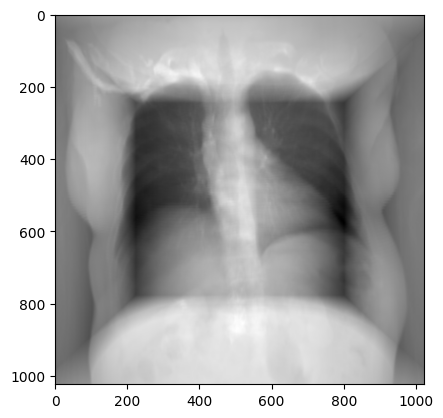

In [47]:
#
# Example of 1 origina image
#

from PIL import Image
import torchvision.transforms as transforms

# Test 1 image
image_path = "data/lidc/Images/Patient0000/Image_00.png" 
image = Image.open(image_path)

# Convert the image to a PyTorch tensor
transform = transforms.ToTensor()
image_tensor = transform(image)

# Verify the tensor shape
print(image_tensor.shape)  
# image_tensor
plt.imshow(image)
plt.show()


### Step 1: collecting multiple images (view) for 1 patient and apply image distortion

This is done by 2 stesp in our pipeline: 

- `LoadMultiViewImageFromFiles`

- `PhotoMetricDistortionMultiViewImage`

The result after this steps: img is of shape `(h, w, c, num_views)` 

Shape of LIDC dataset: `(1024, 1024, 3, 10)`


```python
img = list(tensor)

len(results['img'])
10

results['img'][0].shape
(1024, 1024, 3)
```

Key values of results: 

```python
dict_keys(['sample_idx', 'timestamp', 'img_timestamp', 'img_filename', 'intrinsics', 'extrinsics', 'img_info', 'ann_info', 'img_fields', 'bbox3d_fields', 'bbox2d_fields', 'pts_mask_fields', 'pts_seg_fields', 'bbox_fields', 'mask_fields', 'seg_fields', 'box_type_3d', 'box_mode_3d', 'filename', 'img', 'img_shape', 'ori_shape', 'pad_shape', 'scale_factor', 'img_norm_cfg', 'gt_bboxes_3d', 'gt_labels_3d'])
```

In [18]:
# Load debug var
input_multi_view = load_debug_var("debug_var/input_multi_view.pkl")
print(input_multi_view.keys())

input_multi_view['img_norm_cfg']

Data loaded successfully from debug_var/input_multi_view.pkl
dict_keys(['sample_idx', 'timestamp', 'img_timestamp', 'img_filename', 'intrinsics', 'extrinsics', 'img_info', 'ann_info', 'img_fields', 'bbox3d_fields', 'bbox2d_fields', 'pts_mask_fields', 'pts_seg_fields', 'bbox_fields', 'mask_fields', 'seg_fields', 'box_type_3d', 'box_mode_3d', 'filename', 'img', 'img_shape', 'ori_shape', 'pad_shape', 'scale_factor', 'img_norm_cfg'])


{'mean': array([0., 0., 0.], dtype=float32),
 'std': array([1., 1., 1.], dtype=float32),
 'to_rgb': False}

> Remarks: 
>
> The module will auto init a setting for image normalization
> 
> Our original image has value in [0..1]
>
> After transformation: value in [0..255]

In [33]:
input_multi_view['img_norm_cfg']

{'mean': array([0., 0., 0.], dtype=float32),
 'std': array([1., 1., 1.], dtype=float32),
 'to_rgb': False}

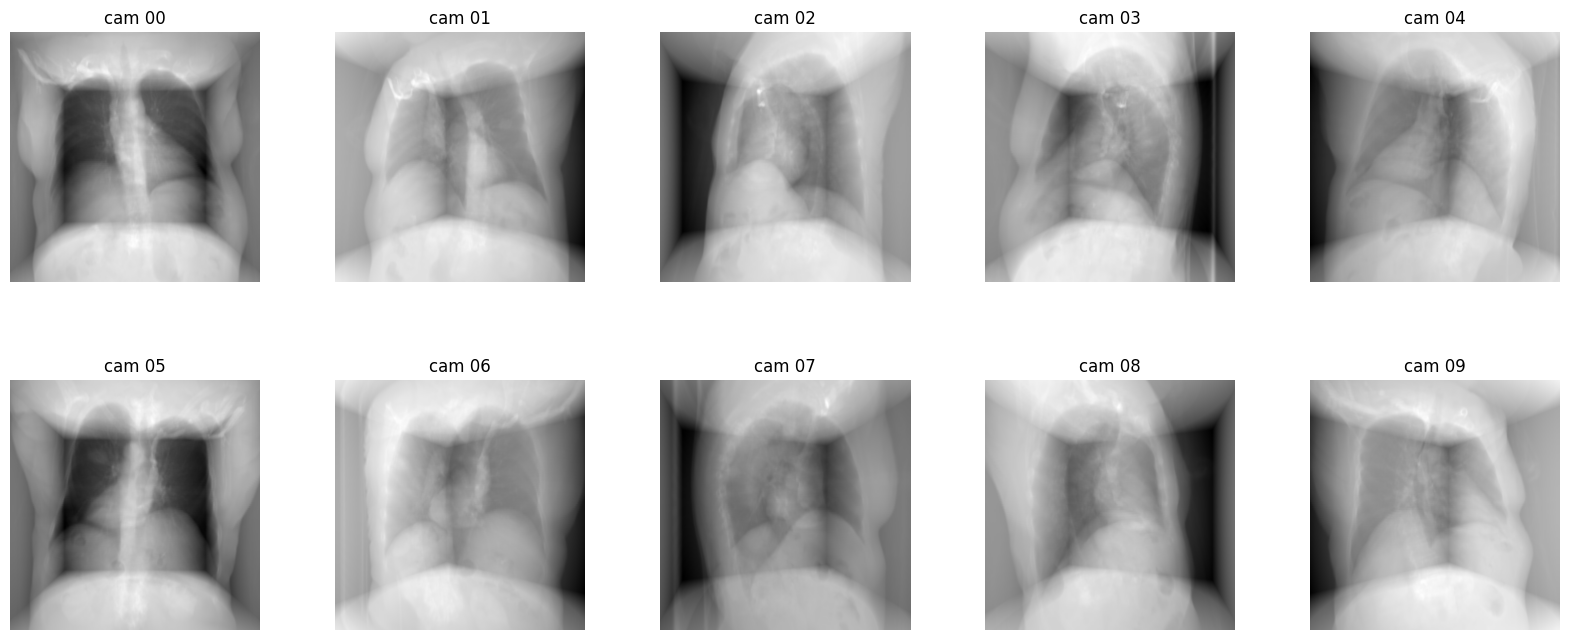

In [37]:
plot_images(input_multi_view['img'])

`PhotMetricDistortionMultiView`

Apply random modification to our original image. 

Update `input['img']` inplace. 

1. random brightness
2. random contrast (mode 0)
3. convert color from BGR to HSV
4. random saturation
5. random hue
6. convert color from HSV to BGR
7. random contrast (mode 1)
8. randomly swap channels

In [71]:
# load debug var
results = load_debug_var("debug_var/input_step1_distort.pkl")
print(results.keys())

print(f"input img shape: {results['img_shape']}")


Data loaded successfully from debug_var/input_step1_distort.pkl
dict_keys(['sample_idx', 'timestamp', 'img_timestamp', 'img_filename', 'intrinsics', 'extrinsics', 'img_info', 'ann_info', 'img_fields', 'bbox3d_fields', 'bbox2d_fields', 'pts_mask_fields', 'pts_seg_fields', 'bbox_fields', 'mask_fields', 'seg_fields', 'box_type_3d', 'box_mode_3d', 'filename', 'img', 'img_shape', 'ori_shape', 'pad_shape', 'scale_factor', 'img_norm_cfg', 'gt_bboxes_3d', 'gt_labels_3d'])
input img shape: (1024, 1024, 3, 10)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


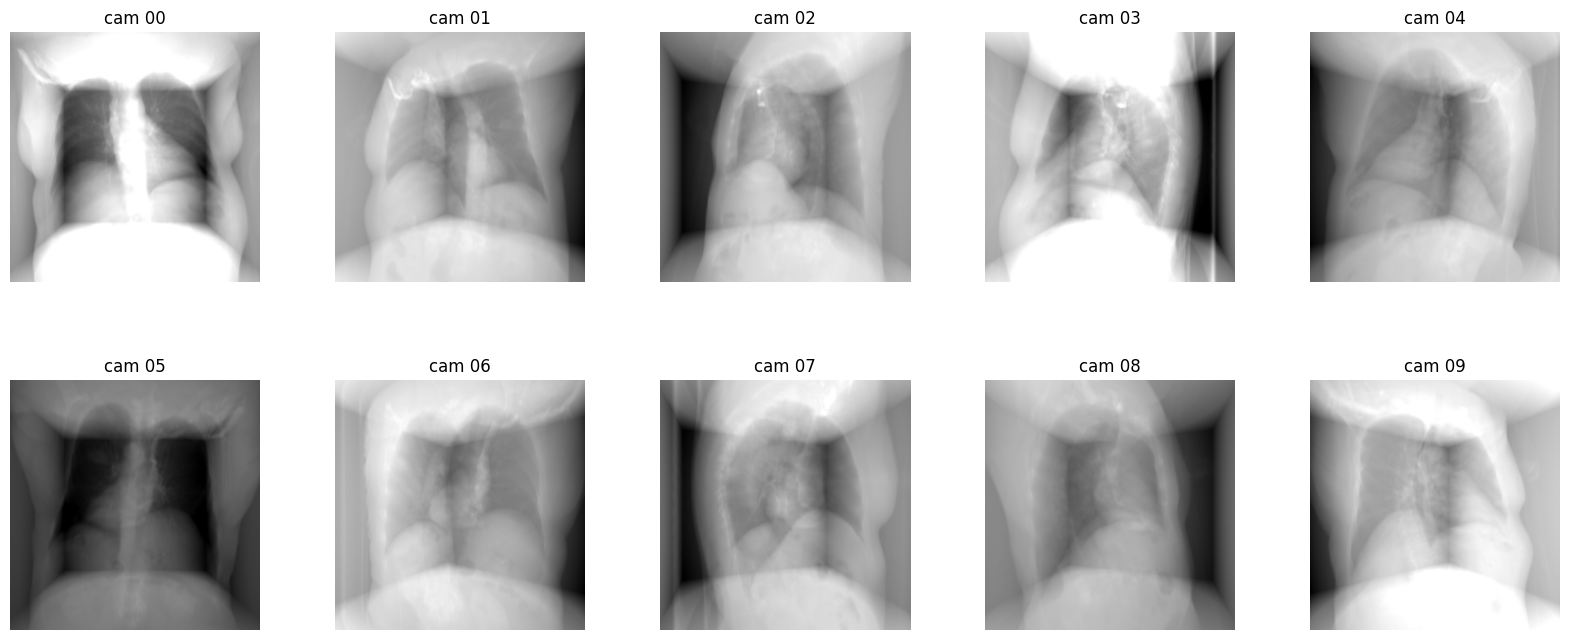

In [72]:
results['img'][0].shape

plot_images(results['img'])

### Step 2: `LoadAnnotationsMono3D`

File: `loading.py`

Function call: 

- add ground truth 2D annotations to our `input_dict`

- doesnt change our input shape. 

Returns: 

`input_dict`

Properties: 

```python
dict_keys(['sample_idx', 'timestamp', 'img_timestamp', 'img_filename', 'intrinsics', 'extrinsics', 'img_info', 'ann_info', 'img_fields', 'bbox3d_fields', 'bbox2d_fields', 'pts_mask_fields', 'pts_seg_fields', 'bbox_fields', 'mask_fields', 'seg_fields', 'box_type_3d', 'box_mode_3d', 'filename', 'img', 'img_shape', 'ori_shape', 'pad_shape', 'scale_factor', 'img_norm_cfg', 'gt_bboxes_3d', 'gt_labels_3d', 'gt_bboxes_2d', 'gt_labels_2d', 'gt_bboxes_2d_to_3d', 'gt_bboxes_ignore'])

len(input_dict['img'])
10

input_dict['img'][0].shape
(1024, 1024, 3)
```

In [74]:
# load debug result
input_step2 = load_debug_var("debug_var/input_step2")
print(input_step2.keys())

print(f"image shape: {input_step2['img_shape']}")

Data loaded successfully from debug_var/input_step2
dict_keys(['sample_idx', 'timestamp', 'img_timestamp', 'img_filename', 'intrinsics', 'extrinsics', 'img_info', 'ann_info', 'img_fields', 'bbox3d_fields', 'bbox2d_fields', 'pts_mask_fields', 'pts_seg_fields', 'bbox_fields', 'mask_fields', 'seg_fields', 'box_type_3d', 'box_mode_3d', 'filename', 'img', 'img_shape', 'ori_shape', 'pad_shape', 'scale_factor', 'img_norm_cfg', 'gt_bboxes_3d', 'gt_labels_3d', 'gt_bboxes_2d', 'gt_labels_2d', 'gt_bboxes_2d_to_3d', 'gt_bboxes_ignore'])
image shape: (1024, 1024, 3, 10)


In [81]:
len(input_step2['gt_bboxes_2d'])
input_step2['gt_bboxes_2d'][0].shape

input_step2['gt_bboxes_2d'][0]

array([[369., 567., 423., 637.],
       [371., 569., 417., 641.],
       [371., 569., 423., 635.],
       [363., 569., 423., 635.]], dtype=float32)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


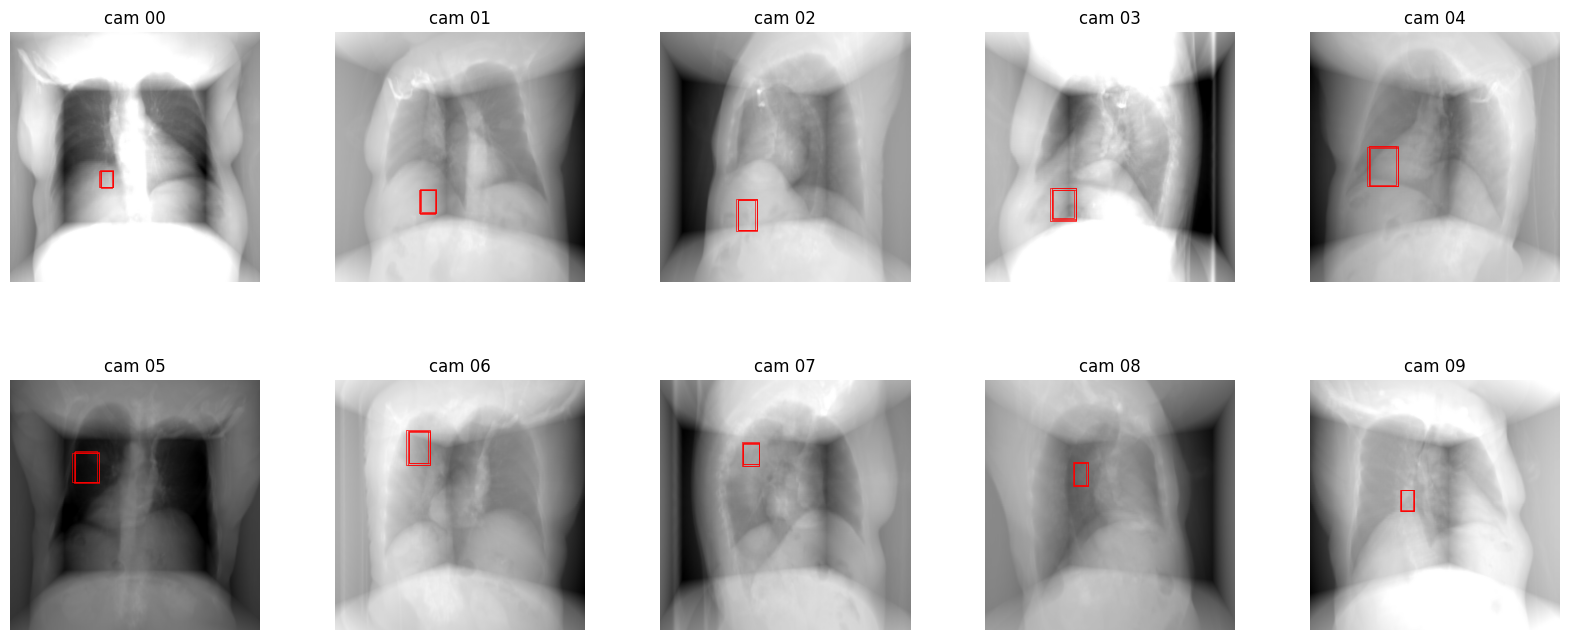

In [89]:
plot_images(input_step2['img'], input_step2['gt_bboxes_2d'])

### Step 3: `ObjectNameFilterMono`

File: `transform_3d.py`

Call function:

- Filter out non-object in gt boxes 3D and 2D. 

- This is done by comparing `['gt_labels_3d]` (from input file) with declared labels (in config file) `self.labels`. 

- Here because we only have 1 target object (0:nodule), the function doesnt modify anything from our input_data

```python
self.labels
[0]

results.keys()
dict_keys(['sample_idx', 'timestamp', 'img_timestamp', 'img_filename', 'intrinsics', 'extrinsics', 'img_info', 'ann_info', 'img_fields', 'bbox3d_fields', 'bbox2d_fields', 'pts_mask_fields', 'pts_seg_fields', 'bbox_fields', 'mask_fields', 'seg_fields', 'box_type_3d', 'box_mode_3d', 'filename', 'img', 'img_shape', 'ori_shape', 'pad_shape', 'scale_factor', 'img_norm_cfg', 'gt_bboxes_3d', 'gt_labels_3d', 'gt_bboxes_2d', 'gt_labels_2d', 'gt_bboxes_2d_to_3d', 'gt_bboxes_ignore'])
```


### Step 4: `ResizeCropFlipImageMono`

File: `transform_3d.py`

Function call: 

- Apply augmentation (resize, crop, horizontal flip, rotate) to original views.  

- Different view use use different aug (BEV Det).

- Bboxes is resized accordingly with imda: 

    - 1. resize

    - 2. crop and filter out-of-image bboxes

    - 3. flip

    - 4. rotate and filter out-of-image bboxes

- This function update our data inplace: 

```python
results["img"] = new_imgs
results['gt_bboxes_2d'] = processed_gt_bboxes_2d
results['gt_labels_2d'] = processed_gt_labels_2d
results['gt_bboxes_2d_to_3d'] = processed_gt_bboxes_2d_to_3d
results['gt_bboxes_ignore'] = processed_gt_bboxes_ignore
```

- The `num_views=6` argument is hard-coded inside the custom function, and there's no passing argument when calling inside the pipeline. We need to chagne it to our setting (`num_views=10`) 

>Remarks: 
> 
> Need to improve to be more robust with custom dataset. 
>

- MV2D uses matrix-multiplication to calculate lidar2img matrix: lidar2img = intrinsic @ extrinsic.T
Comment our because we dont use this in LIDC dataset. 


In [3]:
# load debug result
input_step4 = load_debug_var("debug_var/input_step4.pkl")
print(input_step4.keys())

print(f"image shape: {input_step4['img_shape']}")

Data loaded successfully from debug_var/input_step4.pkl
dict_keys(['sample_idx', 'timestamp', 'img_timestamp', 'img_filename', 'intrinsics', 'extrinsics', 'img_info', 'ann_info', 'img_fields', 'bbox3d_fields', 'bbox2d_fields', 'pts_mask_fields', 'pts_seg_fields', 'bbox_fields', 'mask_fields', 'seg_fields', 'box_type_3d', 'box_mode_3d', 'filename', 'img', 'img_shape', 'ori_shape', 'pad_shape', 'scale_factor', 'img_norm_cfg', 'gt_bboxes_3d', 'gt_labels_3d', 'gt_bboxes_2d', 'gt_labels_2d', 'gt_bboxes_2d_to_3d', 'gt_bboxes_ignore'])
image shape: (1024, 1024, 3, 10)


In [5]:
print("Final image shape: ")
input_step4['img'][0].shape

Final image shape: 


(1024, 1024, 3)

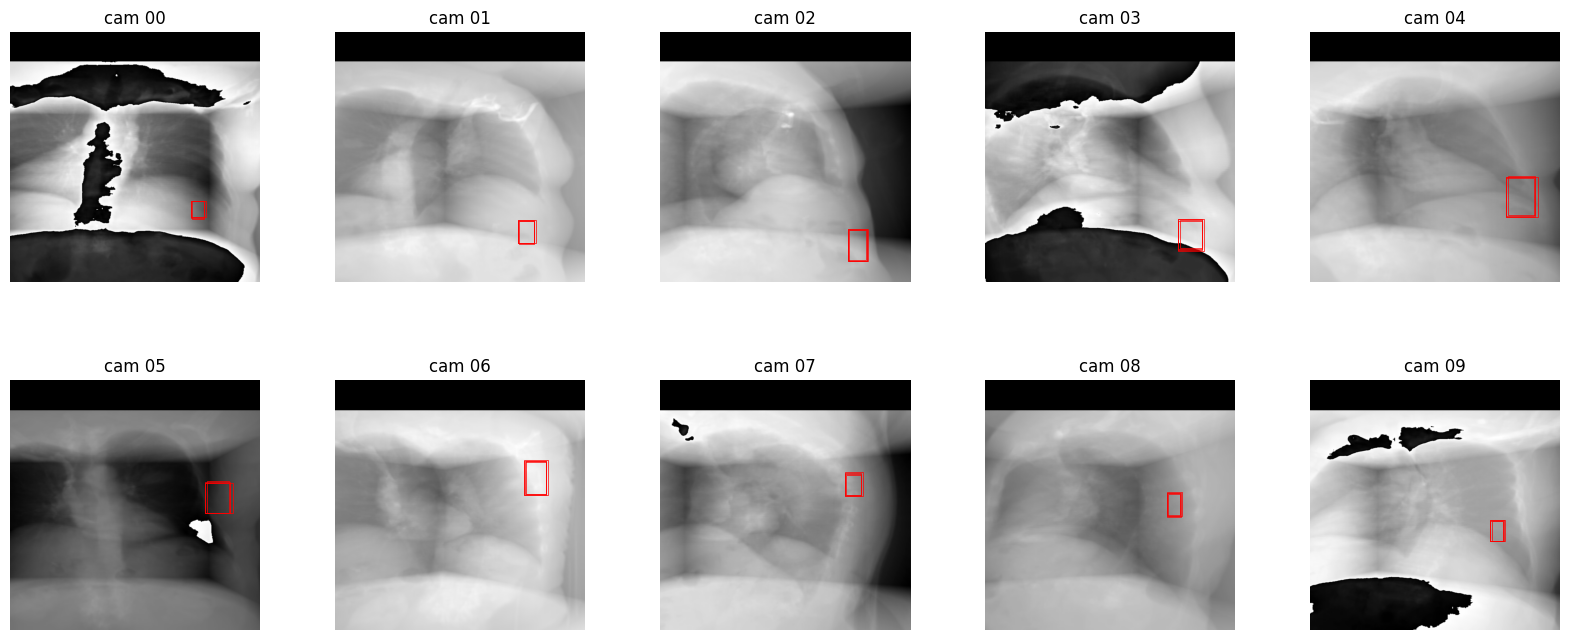

In [6]:
# plot
plot_images(input_step4['img'], input_step4['gt_bboxes_2d'])

### Step 5: `GlobalRotScaleTransImage`

File: `transform_3d.py`

Function call: 

- Random resize, Crop and flip the image

- We can provide input arguments for this function: `(tuple, optional)`

example in MV2D: 

```python
rot_range=[-0.3925, 0.3925],
translation_std=[0, 0, 0],
scale_ratio_range=[0.95, 1.05],
reverse_angle=True,
training=True

```

Return: 

Update our `bt_bboxes_3d` inplace, by:

- rotation: along z-xis

- scale: along xyz. 

```python
results["gt_bboxes_3d"].rotate(...)
results["gt_bboxes_3d"].scale(...)
```



### Step 6: `PadMultiViewImage`

File: `transform_3d.py`

Function call: 

Pad the multi-view image.
There are two padding modes: 

(1) pad to a fixed size and 

(2) pad to the minimum size that is divisible by some number.
    Added keys are "pad_shape", "pad_fixed_size", "pad_size_divisor"

Return: update our input data in fields: 

```python
results['img_shape'] 
results['img']
results['pad_shape'] 
results['pad_fixed_size'] 
results['pad_size_divisor']
```

In [13]:
# load debug result
input_step6 = load_debug_var("debug_var/input_step6.pkl")
print(input_step6.keys())
print(f"img shape: {input_step6['img_shape'][0]}")

Data loaded successfully from debug_var/input_step6.pkl
dict_keys(['sample_idx', 'timestamp', 'img_timestamp', 'img_filename', 'intrinsics', 'extrinsics', 'img_info', 'ann_info', 'img_fields', 'bbox3d_fields', 'bbox2d_fields', 'pts_mask_fields', 'pts_seg_fields', 'bbox_fields', 'mask_fields', 'seg_fields', 'box_type_3d', 'box_mode_3d', 'filename', 'img', 'img_shape', 'ori_shape', 'pad_shape', 'scale_factor', 'img_norm_cfg', 'gt_bboxes_3d', 'gt_labels_3d', 'gt_bboxes_2d', 'gt_labels_2d', 'gt_bboxes_2d_to_3d', 'gt_bboxes_ignore', 'pad_fixed_size', 'pad_size_divisor'])
img shape: (1024, 1024, 3)


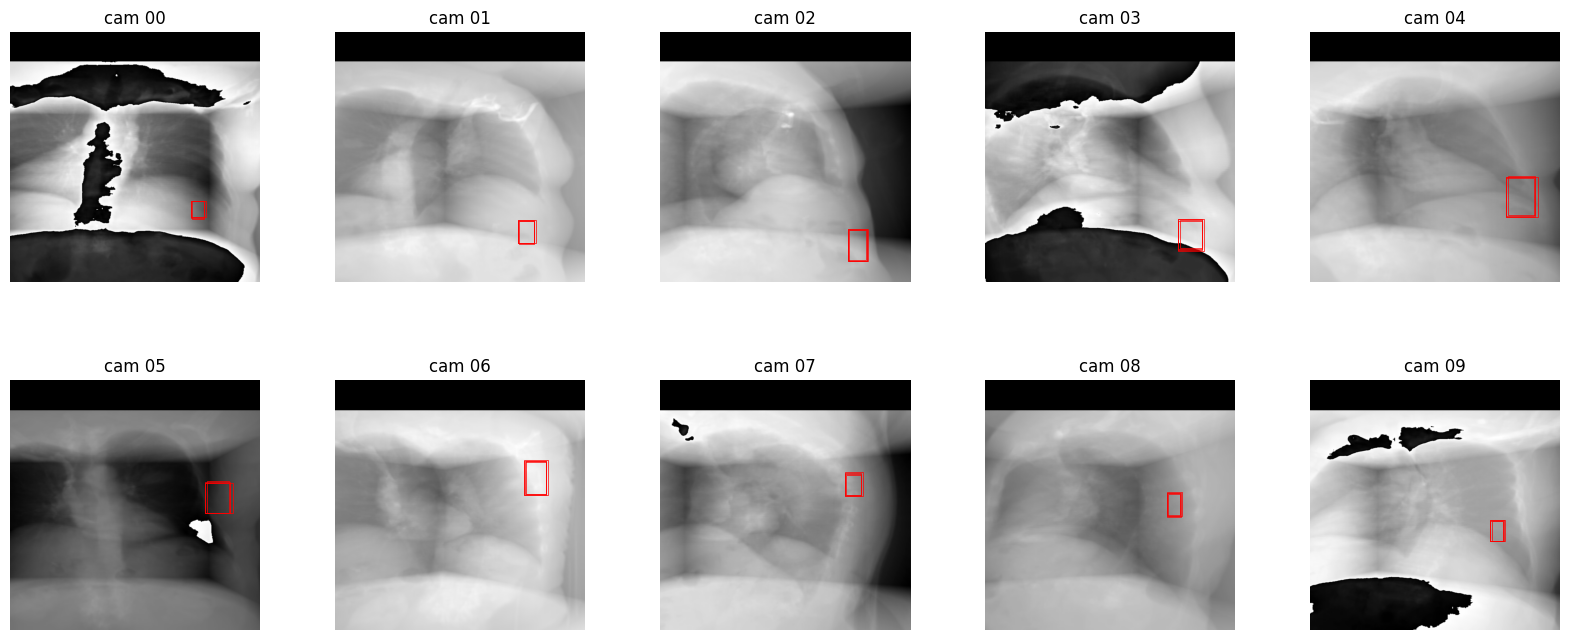

In [20]:
plot_images(input_step6['img'],input_step6['gt_bboxes_2d'])

### Step 7: `DefaultFormatBundleMono3D`

File: `formatting.py`

Function call: 

- Collect all list of ground truth boxes (2D, 3D) into `DataContainer` and send data to tensor. 

- Mostly for `mmcv` parallel computing purpose. 

- Does not change our data in place (exept packing ground truth boxes into data container)

### Step 8: `CollectMono3D`

File: `formatting.py`

Function call: 

- Collect data from the loader relevant to the specific task. This is usually the last stage of the data loader pipeline. 

- keys: ['gt_bboxes_3d', 'gt_labels_3d', 'gt_bboxes_2d', 'gt_labels_2d', 'gt_bboxes_2d_to_3d', 'gt_bboxes_ignore', 'img']

In [31]:
# load debug result
input_final = load_debug_var("debug_var/input_final.pkl")
print(input_final.keys())
print(f"Final input size: {input_final['img'].size()}")

Data loaded successfully from debug_var/input_final.pkl
dict_keys(['sample_idx', 'timestamp', 'img_timestamp', 'img_filename', 'intrinsics', 'extrinsics', 'img_info', 'ann_info', 'img_fields', 'bbox3d_fields', 'bbox2d_fields', 'pts_mask_fields', 'pts_seg_fields', 'bbox_fields', 'mask_fields', 'seg_fields', 'box_type_3d', 'box_mode_3d', 'filename', 'img', 'img_shape', 'ori_shape', 'pad_shape', 'scale_factor', 'img_norm_cfg', 'gt_bboxes_3d', 'gt_labels_3d', 'gt_bboxes_2d', 'gt_labels_2d', 'gt_bboxes_2d_to_3d', 'gt_bboxes_ignore', 'pad_fixed_size', 'pad_size_divisor'])
Final input size: torch.Size([10, 3, 1024, 1024])


# Build model

We will init our pretrained model with checkpoint: `mask_rcnn_r50_fpn_1x_nuim_20201008_195238-e99f5182.pth` from `mmdetection3d`. The pretrained weight is trained on `nuImages` dataset, using Mask-RCNN method with R-50 backbone. [link github](https://github.com/open-mmlab/mmdetection3d/tree/main/configs/nuimages)

In [38]:
model = build_model(
    cfg.model,
    train_cfg=cfg.get('train_cfg'),
    test_cfg=cfg.get('test_cfg'))
model.init_weights()

logger.info(f'Model:\n{model}')

2025-01-05 22:10:16,950 - mmdet - INFO - initialize TwoStageDetBase with init_cfg {'type': 'Pretrained', 'checkpoint': './weights/mask_rcnn_r50_fpn_1x_nuim_20201008_195238-e99f5182.pth'}
2025-01-05 22:10:16,951 - mmcv - INFO - load model from: ./weights/mask_rcnn_r50_fpn_1x_nuim_20201008_195238-e99f5182.pth
2025-01-05 22:10:16,952 - mmcv - INFO - load checkpoint from local path: ./weights/mask_rcnn_r50_fpn_1x_nuim_20201008_195238-e99f5182.pth
2025-01-05 22:10:17,077 - mmcv - WARNING - The model and loaded state dict do not match exactly

unexpected key in source state_dict: roi_head.mask_head.convs.0.conv.weight, roi_head.mask_head.convs.0.conv.bias, roi_head.mask_head.convs.1.conv.weight, roi_head.mask_head.convs.1.conv.bias, roi_head.mask_head.convs.2.conv.weight, roi_head.mask_head.convs.2.conv.bias, roi_head.mask_head.convs.3.conv.weight, roi_head.mask_head.convs.3.conv.bias, roi_head.mask_head.upsample.weight, roi_head.mask_head.upsample.bias, roi_head.mask_head.conv_logits.weight

Our model is not `EncoderDecoder3D`, thus our training process will follow `train_detector` procedure. 

>Related source code: 
>
> in `train.py`

```python
    if cfg.model.type in ['EncoderDecoder3D']:
        train_segmentor(
            model,
            dataset,
            cfg,
            distributed=distributed,
            validate=validate,
            timestamp=timestamp,
            meta=meta)
    else:
        train_detector(
            model,
            dataset,
            cfg,
            distributed=distributed,
            validate=validate,
            timestamp=timestamp,
            meta=meta)
```


In [39]:
model.base_detector.backbone

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): ResLayer(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1)

## Feature extraction

In [55]:
img = input_final['img'].data
img.shape

with torch.no_grad():
    out_feat = model.base_detector.extract_feat(img)

In [86]:
print(len(out_feat))

for i, l in enumerate(out_feat): 
    print(f"Level {i+1}: {l.shape}")
    print
# out_feat[0].shape

5
Level 1: torch.Size([10, 256, 256, 256])
Level 2: torch.Size([10, 256, 128, 128])
Level 3: torch.Size([10, 256, 64, 64])
Level 4: torch.Size([10, 256, 32, 32])
Level 5: torch.Size([10, 256, 16, 16])


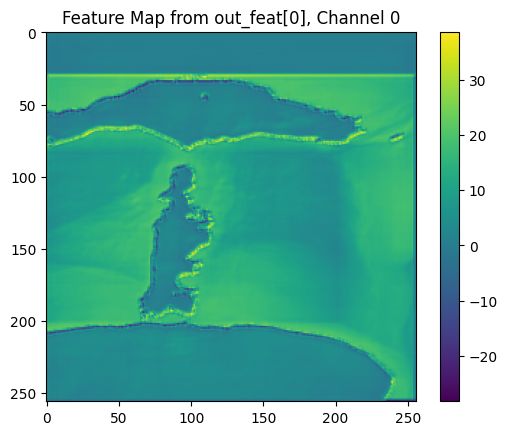

In [71]:
feature_map = out_feat[0][0, 0, :, :]  # Shape: (256, 256)


plt.imshow(feature_map.cpu().numpy(), cmap='viridis')  
plt.colorbar()
plt.title("Feature Map from out_feat[0], Channel 0")
plt.show()


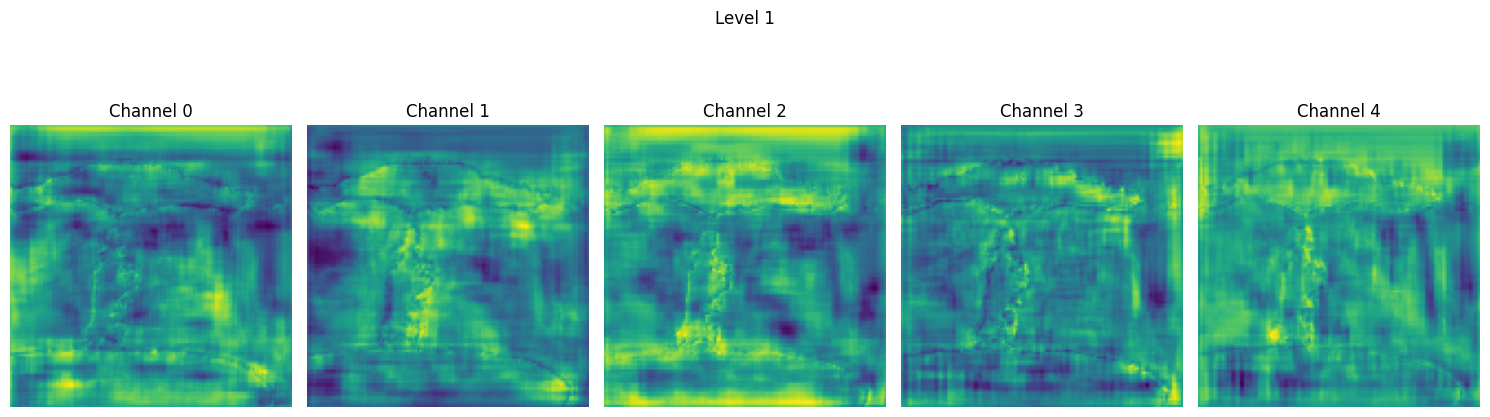

In [95]:
num_channels = 5
level = 1

fig, axes = plt.subplots(1, num_channels, figsize=(15, 5))
for i in range(num_channels):
    feature_map = out_feat[level][0, i, :, :]
    axes[i].imshow(feature_map.cpu().numpy(), cmap='viridis')
    axes[i].set_title(f"Channel {i}")
    axes[i].axis('off')

plt.suptitle(f"Level {level}")
plt.tight_layout()
plt.show()


In [75]:
from torch.utils.tensorboard import SummaryWriter
import torch

# Example feature map from out_feat[0]
feature_map = out_feat[0][0, 0, :, :]  # Shape: (256, 256)

# Add a channel dimension to match TensorBoard's expected shape
feature_map = feature_map.unsqueeze(0)  # Shape: (1, 256, 256)

# Convert to a supported data type (e.g., float32 or uint8)
feature_map = feature_map.float()  # Ensure it is float32
feature_map = (feature_map - feature_map.min()) / (feature_map.max() - feature_map.min())  # Normalize to [0, 1]

# Save the image to TensorBoard
writer = SummaryWriter()
writer.add_image("Feature Map", feature_map, dataformats="CHW")  # Dataformats indicates (C, H, W)
writer.close()


## forward pass with backbone Resnet


In [101]:
model.base_detector.backbone

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): ResLayer(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1)

In [102]:
with torch.no_grad():
    out_backbone = model.base_detector.backbone(img)

In [117]:
print(len(out_backbone))

for i, l in enumerate(out_backbone): 
    print(f"Level {i+1}: {l.shape}")
    print

4
Level 1: torch.Size([10, 256, 256, 256])
Level 2: torch.Size([10, 512, 128, 128])
Level 3: torch.Size([10, 1024, 64, 64])
Level 4: torch.Size([10, 2048, 32, 32])


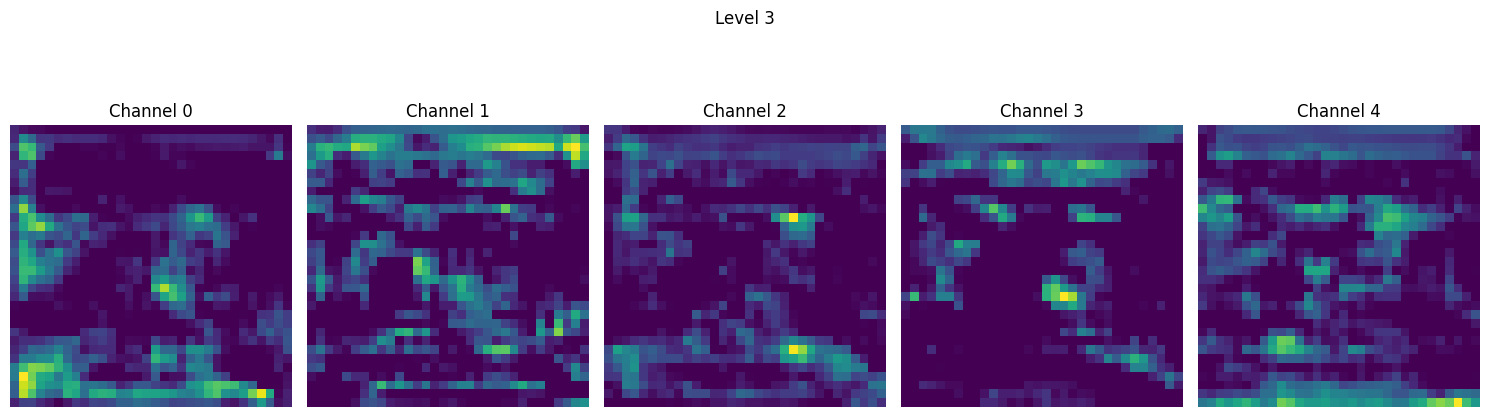

In [116]:
num_channels = 5
level = 3

fig, axes = plt.subplots(1, num_channels, figsize=(15, 5))
for i in range(num_channels):
    feature_map = out_backbone[level][0, i, :, :]
    axes[i].imshow(feature_map.cpu().numpy(), cmap='viridis')
    axes[i].set_title(f"Channel {i}")
    axes[i].axis('off')

plt.suptitle(f"Level {level}")
plt.tight_layout()
plt.show()
